Finite Difference based 1D Nonlinerar Possion Equation Solver for pn-Junctions

https://lampz.tugraz.at/~hadley/psd/L6/poisson/pn_poisson_calc_live.html

Richard S.Muller, Device Electronics for Integrated Circuits, page 110

In [50]:
# doping profile

import numpy as np
import matplotlib.pyplot as plt

def band_initialization(NA, ND, ni, q, kB, T):
    dN = ND - NA
    V = np.zeros_like(dN)
    for i in range(len(V)):
        if abs(dN[i]) >= ni:
            V[i] = np.sign(dN[i]) * kB * T / q * np.log(abs(dN[i]) / ni)
    return V

def heaviside(x):
    return np.heaviside(x, 1.0)  # same as MATLAB's heaviside with 1 at x=0

def doping_profiles(profile_type, x):
    NA = np.zeros_like(x)
    ND = np.zeros_like(x)

    #NA=1e15, ND=1e16, can not calculate when exchange NA and ND.
    if profile_type == 'abrupt':
        NA[:] = NA1 * 1e6  # convert to 1/m^3
        ND = np.where(x >= 0, ND1, 0) * 1e6

    elif profile_type == 'linear':
        alpha = 1e19 * 100e6  # 1/m^4
        for i in range(len(x)):
            if x[i] <= 0:
                NA[i] = -alpha * x[i]
            else:
                ND[i] = alpha * x[i]

    elif profile_type == 'hyper_abrupt':
        NA = 1e15 * np.exp(0.5 * (x / 1e-6)) * heaviside(-x)
        ND = 1e15 * np.exp(0.5 * (-x / 1e-6)) * heaviside(x)
        NA *= 1e6
        ND *= 1e6

    elif profile_type == 'abrupt_pnp':
        NA = (heaviside(-x - 1e-6) * NE + heaviside(x + 1e-6) * NC) * 1e6
        ND = (heaviside(x + 1e-6) * NB - heaviside(x - 1e-6) * NB) * 1e6

    elif profile_type == 'abrupt_npn':
        ND = (heaviside(-x - 1e-6) * NE + heaviside(x + 1e-6) * NC) * 1e6
        NA = (heaviside(x + 1e-6) * NB - heaviside(x - 1e-6) * NB) * 1e6

    elif profile_type == 'abrupt_pnpn':
        NA = (heaviside(-x - 2e-6) * 1e18 +
              (heaviside(x - 2e-6) - heaviside(x - 3e-6)) * 0.8e18) * 1e6
        ND = ((heaviside(x + 2e-6) - heaviside(x - 2e-6)) * 5e17 +
              heaviside(x - 3e-6) * 1.2e18) * 1e6

    elif profile_type == 'abrupt_npnp':
        ND = (heaviside(-x - 2e-6) * 1e18 +
              (heaviside(x - 2e-6) - heaviside(x - 3e-6)) * 0.8e18) * 1e6
        NA = ((heaviside(x + 2e-6) - heaviside(x - 2e-6)) * 5e17 +
              heaviside(x - 3e-6) * 1.2e18) * 1e6

    elif profile_type == 'arbitrary':
        NA, ND = my_profile(x)

    else:
        raise ValueError(f"[ERROR]: {profile_type} is not a valid doping profile!")

    return NA, ND

def my_profile(x):
    NA = np.ones_like(x) * 1e15 * 1e6
    ND = np.exp(-(x / 1e-6) ** 2) * 1e17 * 1e6
    return NA, ND


Number of Newton-Raphson Iterations: 6
Built-in Voltage Vbi: 0.0000 V


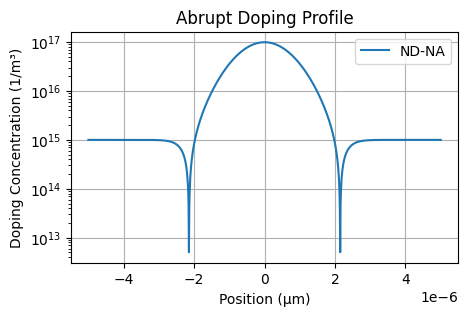

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
#from scipy.constants import epsilon_0, k, e

# Declaration of constants
T = 300 # degreeK
eps_0 = 8.854187813e-12 #As/Vm, permittivity 8.854e-14 F/cm(1/(mu_0*c^2))
eps_r = 11.7
epsilon = eps_0 * eps_r
kB = 1.380658e-23 #J/K
q = 1.60217733e-19 #As
ni = 1.45e16 # 1/m^3
Eg = 1.12 # eV

# Domain
xmin, xmax = -5e-6, 5e-6
N = 1000
x = np.linspace(xmin, xmax, N)
dx = x[1] - x[0]
xg = np.concatenate(([x.min() - dx], x, [x.max() + dx]))

# Newton Raphson paratmeters
maxIter = 500
alpha = 1e-8
'''
# Get doping abrupt_pnp, abrupt_npn
NE=5e17
NB=1e16
NC=1e15
get_doping_profile = 'abrupt_pnp'
NA, ND = doping_profiles(get_doping_profile, x)
'''
'''
#abrupt junction, ND1 should be bigger than NA1
NA1=1e15
ND1=5e15
get_doping_profile = 'abrupt'
NA, ND = doping_profiles(get_doping_profile, x)
'''

#linear, hyper_abrupt, abrupt_pnpn, abrupt_npnp, arbitrary(NA<ND)
get_doping_profile = 'arbitrary'
NA, ND = doping_profiles(get_doping_profile, x)

# Initial charge carriers
n = ND.copy()
p = NA.copy()

# Initial potential
V = np.zeros_like(xg)
Vinit = band_initialization(NA, ND, ni, q, kB, T)
V[1:N+1] = Vinit
V[0] = V[1]
V[-1] = V[-2]
V_old = V.copy()

# Newton-Raphson iteration
for k in range(1, maxIter + 1):
    n = ni * np.exp(q * V[1:N+1] / (kB * T))
    p = ni * np.exp(-q * V[1:N+1] / (kB * T))
    
    rho = q * (p - n + ND - NA)
    drho_dV = -2 * q**2 * ni / (kB * T) * np.cosh(q * V[1:N+1] / (kB * T))
    
    d2V_dx2 = (V[0:N] - 2 * V[1:N+1] + V[2:N+2]) / dx**2
    
    Mjj_k = 2 / dx**2 - (1 / epsilon) * drho_dV
    M_off = np.ones(N) / dx**2
    M_k = spdiags([-M_off, Mjj_k, -M_off], [-1, 0, 1], N, N).tocsc()
    R_k = (1 / epsilon) * rho + d2V_dx2
    
    delta_V = np.linalg.solve(M_k.toarray(), R_k)
    V[1:N+1] += delta_V

    if np.linalg.norm(V - V_old, ord=np.inf) < alpha:
        break

    V_old = V.copy()

# Electric field
E = -np.diff(V[:N+1]) / dx
Vbi = np.abs(V[-1] - V[0])

# Output results
print(f"Number of Newton-Raphson Iterations: {k}")
print(f"Built-in Voltage Vbi: {Vbi:.4f} V")

# doping profile
plt.figure(1,figsize=(5,3))
#plt.semilogy(x, NA*1e-6, label='NA')
#plt.semilogy(x, ND*1e-6, label='ND')
plt.semilogy(x, np.abs(ND-NA)*1e-6, label='ND-NA')
plt.xlabel('Position (µm)'), plt.ylabel('Doping Concentration (1/m³)')
plt.title('Abrupt Doping Profile'), plt.legend(), plt.grid(True)
plt.show()

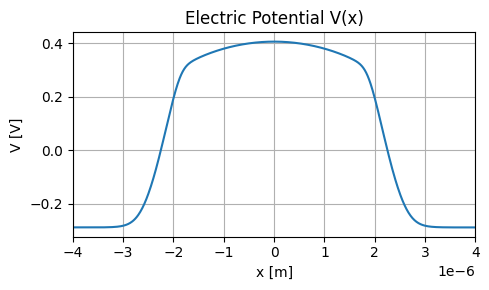

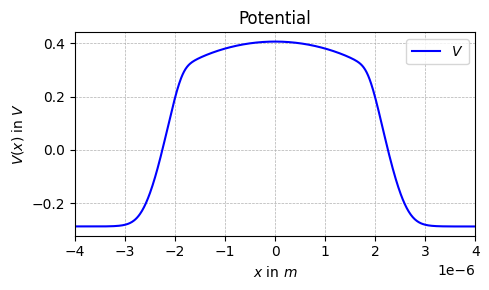

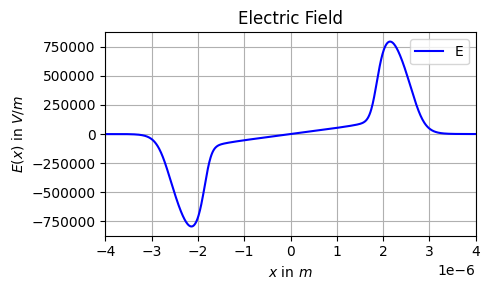

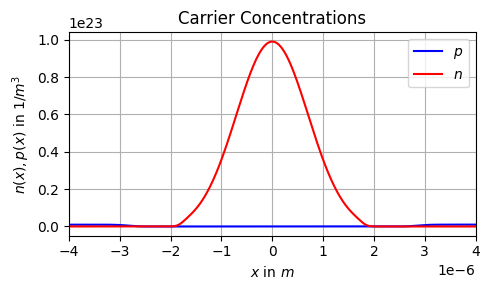

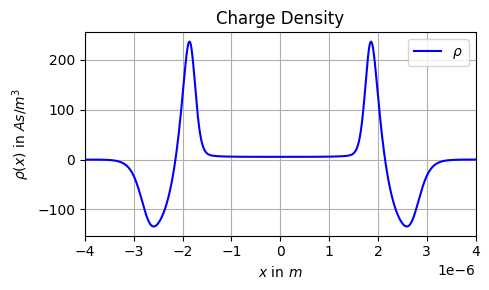

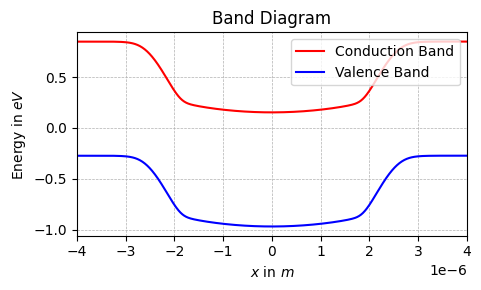

In [52]:
# Electric potential
plt.figure(2,figsize=(5,3))
plt.plot(x, V[1:-1])
plt.title("Electric Potential V(x)")
plt.xlabel("x [m]"), plt.ylabel("V [V]")
plt.xlim(-4e-6,4e-6), plt.grid(True) #, plt.ylim(-0.4, 0.4), 
plt.tight_layout()

# potential
plt.figure(6,figsize=(5,3))
plt.plot(x, V[1:-1], 'b', label=r'$V$', linewidth=1.5)  # V(2:N+1) -> V[1:-1] in Python

plt.title('Potential')
plt.xlabel(r'$x$ in $m$')
plt.ylabel(r'$V(x)$ in $V$')
plt.xlim(-4e-6,4e-6) #, plt.ylim(-0.4, 0.4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # grid minor와 비슷한 느낌
plt.legend(loc='upper right')  # 'northeastoutside'에 가까운 위치
plt.tight_layout()

# Electric Field
plt.figure(5,figsize=(5,3))
plt.plot(x[:-1], E[:-1], 'b', label="E", linewidth=1.5)  # E도 x[:-1]에 맞춰 자름

plt.title('Electric Field')
plt.xlabel(r'$x$ in $m$')
plt.ylabel(r'$E(x)$ in $V/m$')
plt.xlim(-4e-6, 4e-6), #plt.ylim(-2e6, 2e6)
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()

# Carrier Concentration Plot
plt.figure(3,figsize=(5,3))
plt.plot(x, p, 'b', label='$p$', linewidth=1.5)  # hole concentration
plt.plot(x, n, 'r', label='$n$', linewidth=1.5)  # electron concentration
plt.title('Carrier Concentrations')
plt.xlabel('$x$ in $m$'), plt.ylabel('$n(x), p(x)$ in $1/m^3$')
plt.xlim(-4e-6,4e-6) #, plt.ylim(1, 6e21)
plt.grid(True, which='both')
plt.legend(loc='upper right')  # similar to 'northeastoutside'
plt.tight_layout()

# charge density
plt.figure(4,figsize=(5,3))
plt.plot(x, rho, 'b', label=r'$\rho$', linewidth=1.5)

plt.title('Charge Density')
plt.xlabel(r'$x$ in $m$'), plt.ylabel(r'$\rho(x)$ in $As/m^3$')
plt.xlim(-4e-6,4e-6) #, plt.ylim(-1000, 400)
plt.grid(True, which='both')
plt.legend(loc='upper right')
plt.tight_layout()

# band diagram
plt.figure(7,figsize=(5,3))
plt.plot(x, -V[1:-1] + Eg / 2, 'r', label='Conduction Band', linewidth=1.5)
plt.plot(x, -V[1:-1] - Eg / 2, 'b', label='Valence Band', linewidth=1.5)

plt.title('Band Diagram')
plt.xlabel(r'$x$ in $m$')
plt.ylabel('Energy in $eV$')
plt.xlim(-4e-6,4e-6) #, plt.ylim(-1, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')  # 'northeastoutside'에 가장 가까운 위치
plt.tight_layout()
plt.show()